# Dataset utilizado
Os exercícios deverão utilizar o dataset MovieLens [1]. Essa base de dados vem de um sistema de
recomendação de filmes desenvolvido pelo GroupLens e possui 100.000 avaliações. Nela existem 943
usuários e 1682 filmes, e o seu conjunto de preferência é um número inteiro que varia entre um a cinco.
Além das avaliações, existem informações sobre usuários, como a idade e o sexo, e sobre os filmes,
tais como título do filme e a data de lançamento do filme. Essas informações não serão utilizadas nos
exercícios dessa lista.

[Link para o dataset](https://grouplens.org/datasets/movielens/100k/)

In [1]:
using DataFrames;
using CSV;
using Plots;
using Statistics;
using MLJ;
using MLJScientificTypes;
using DataTables;

In [2]:
# Carregando os datasets
ratingsDF = CSV.read("../data/ml-100k/u.data", DataFrame, header=["user_id", "item_id", "rating", "timestamp"]);
usersDF = CSV.read("../data/ml-100k/u.user", DataFrame);
moviesDF = CSV.read("../data/ml-100k/u.item", DataFrame, header=["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]);

# Exercício 1
Gere um gráfico que mostre a quantidade de avaliações de cada usuário. Ordene pela quantidade de avaliações.

In [3]:
ratingPerUserDF = combine(groupby(ratingsDF, [:user_id]), nrow => :ratingCount)

# Ordenando os usuários por quantidade de avaliações
sort!(ratingPerUserDF, :ratingCount)

,user_id,ratingCount
,Int64,Int64
1,166,20
2,242,20
3,19,20
4,36,20
5,93,20
6,143,20
7,202,20
8,147,20
9,34,20


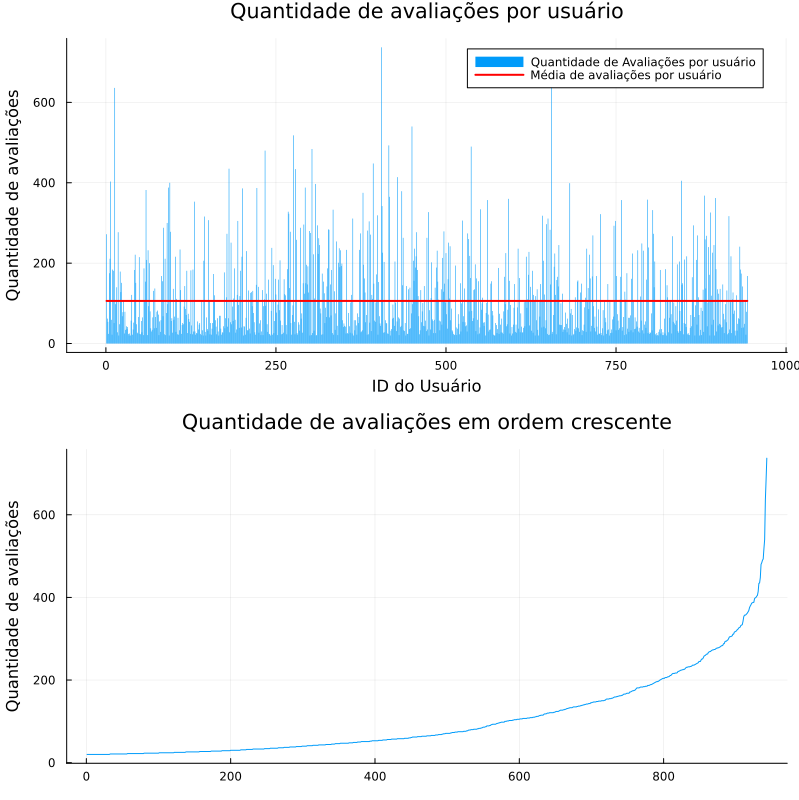

In [4]:
p1 = bar(ratingPerUserDF.user_id, ratingPerUserDF.ratingCount, title="Quantidade de avaliações por usuário", xlabel="ID do Usuário", ylabel="Quantidade de avaliações", label = "Quantidade de Avaliações por usuário", linecolor=nothing)
p1 = plot!(fill(mean(ratingPerUserDF.ratingCount), 943), label="Média de avaliações por usuário", linewidth = 2, color=:red)

p2 = plot(ratingPerUserDF.ratingCount, legend=false, title="Quantidade de avaliações em ordem crescente", ylabel="Quantidade de avaliações")

plot(p1, p2, layout=(2,1), size=(800, 800))

# Exercício 2
Gere o histograma das notas, ou seja, quantos usuários deram nota um, quantos deram nota dois e assim por adiante.

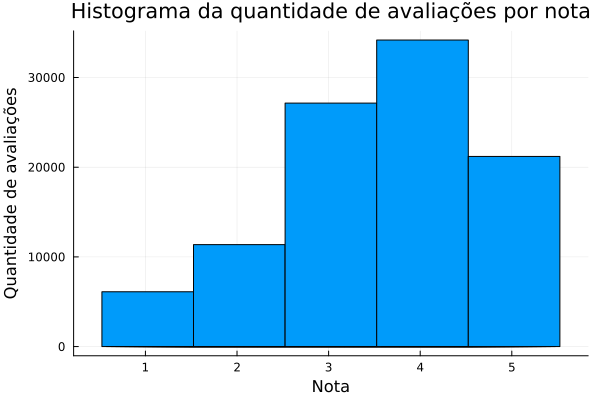

In [5]:
histogram(ratingsDF.rating, title="Histograma da quantidade de avaliações por nota", bar_width=1,formatter=:plain, legend=false, xlabel="Nota", ylabel="Quantidade de avaliações")

# Exercício 3
Gere a lista dos dez filmes mais bem mais avaliados do conjunto de dados.

In [6]:
# Pegando a média de cada filme
meanRatingPerMovieDF = combine(groupby(ratingsDF, [:item_id]), nrow => :ratingCount, :rating => mean => :ratingMean)

# Pegando o nome dos filmes
meanRatingPerMovieDF.item_title = moviesDF.movie_title[meanRatingPerMovieDF.item_id]

# Ordenando colunas
select!(meanRatingPerMovieDF, [:item_id, :item_title, :ratingCount, :ratingMean])

# Ordenando os filmes por média de nota
sort!(meanRatingPerMovieDF, :ratingMean, rev=true)

first(meanRatingPerMovieDF, 10)

,item_id,item_title,ratingCount,ratingMean
,Int64,String,Int64,Float64
1,1189,Prefontaine (1997),3,5.0
2,1500,Santa with Muscles (1996),2,5.0
3,814,"Great Day in Harlem, A (1994)",1,5.0
4,1536,Aiqing wansui (1994),1,5.0
5,1293,Star Kid (1997),3,5.0
6,1599,Someone Else's America (1995),1,5.0
7,1653,Entertaining Angels: The Dorothy Day Story (1996),1,5.0
8,1467,"Saint of Fort Washington, The (1993)",2,5.0
9,1122,They Made Me a Criminal (1939),1,5.0


In [7]:
# Pegando apenas filmes com mais de 50 avaliações
meanRatingPerMovieBetterDF = copy(meanRatingPerMovieDF)
delete!(meanRatingPerMovieBetterDF, findall(meanRatingPerMovieBetterDF.ratingCount .< 50))

first(meanRatingPerMovieBetterDF, 10)

,item_id,item_title,ratingCount,ratingMean
,Int64,String,Int64,Float64
1,408,"Close Shave, A (1995)",112,4.49107
2,318,Schindler's List (1993),298,4.46644
3,169,"Wrong Trousers, The (1993)",118,4.4661
4,483,Casablanca (1942),243,4.45679
5,114,Wallace & Gromit: The Best of Aardman Animation (1996),67,4.44776
6,64,"Shawshank Redemption, The (1994)",283,4.44523
7,603,Rear Window (1954),209,4.38756
8,12,"Usual Suspects, The (1995)",267,4.38577
9,50,Star Wars (1977),583,4.35849


# Exercício 4
Gere a mesmo lista do exercício anterior, mas utilizando a Damped Mean com k igual a 30. Faça uma comparação com o exercício anterior.

In [8]:
globalMean = mean(ratingsDF.rating)

function dampedMeanMovies(itr)
    return (sum(itr) + 30 * globalMean) / (length(itr) + 30)
end

# Pegando a damped mean de cada filme
DampedMeanRatingPerMovieDF = combine(groupby(ratingsDF, [:item_id]), nrow => :ratingCount, :rating => dampedMeanMovies => :ratingDampedMean, :rating => mean => :ratingMean)

# Pegando o nome dos filmes
DampedMeanRatingPerMovieDF.item_title = moviesDF.movie_title[DampedMeanRatingPerMovieDF.item_id]

# Ordenando colunas
select!(DampedMeanRatingPerMovieDF, [:item_id, :item_title, :ratingCount, :ratingMean ,:ratingDampedMean])

# Ordenando os filmes por média de nota
sort!(DampedMeanRatingPerMovieDF, :ratingDampedMean, rev=true)

first(DampedMeanRatingPerMovieDF, 10)

,item_id,item_title,ratingCount,ratingMean,ratingDampedMean
,Int64,String,Int64,Float64,Float64
1,318,Schindler's List (1993),298,4.46644,4.38078
2,64,"Shawshank Redemption, The (1994)",283,4.44523,4.35749
3,483,Casablanca (1942),243,4.45679,4.35493
4,50,Star Wars (1977),583,4.35849,4.31794
5,12,"Usual Suspects, The (1995)",267,4.38577,4.29931
6,408,"Close Shave, A (1995)",112,4.49107,4.288
7,603,Rear Window (1954),209,4.38756,4.2799
8,169,"Wrong Trousers, The (1993)",118,4.4661,4.27632
9,98,"Silence of the Lambs, The (1991)",390,4.28974,4.23547


# Exercício 5
Divida a base aleatoriamente em 80% e 20%. O primeiro será chamado de base de treinamento e a segunda base de teste. Calcule a média das notas de cada usuário na base de treinamento. Caso não tenha nenhuma avaliação considere a média global. Depois na base de teste você irá prever as notas e utilizará a média do usuário como previsão. Por fim, calcule a média do erro ($ MAE = {1 \over n} \sum _{u,v} |p_{uv} - r_{uv}|$, onde $p_{uv}$ é a nota prevista de um usuário $u$ para um item $v$ e $r_{uv}$ é a nota de um usuário $u$ para um item $v$.) da base de teste autilizando essa nota prevista.

In [9]:
dt = DataTable(ratingsDF)
train, test = partition(eachindex(dt), 0.8, shuffle=true, rng=123)

ratingTrainDF = ratingsDF[train, :];
ratingTestDF = ratingsDF[test, :];
println("Tamanho do dataset de treino: ", size(ratingTrainDF))
println("Tamanho do dataset de test: ", size(ratingTestDF))

Tamanho do dataset de treino: (80000, 4)
Tamanho do dataset de test: (20000, 4)


In [10]:
# Função que retorna a nota de acordo com o usuário
function predict(train, user_id, globalMean)
    if user_id in train.user_id
        return train.ratingMean[train.user_id .== user_id][1]
    else
        return globalMean
    end
end

predict (generic function with 1 method)

In [11]:
# Calculando a média de cada usuário da base de treino
ratingMeanTrainDF = combine(groupby(ratingTrainDF, [:user_id]), nrow => :ratingCount, :rating => mean => :ratingMean)

# Calculando a média global
globalMean = mean(ratingTrainDF.rating)

# Calculando as notas preditas na base de teste
ratingTestDF.pred = [predict(ratingMeanTrainDF, user_id, globalMean) for user_id in ratingTestDF.user_id];
ratingTestDF

,user_id,item_id,rating,timestamp,pred
,Int64,Int64,Int64,Int64,Float64
1,207,514,4,877878343,3.22905
2,49,7,4,888067307,2.68182
3,612,237,3,875324455,3.31818
4,537,730,3,886031211,2.83073
5,654,408,5,887863381,3.70833
6,183,54,2,891467546,3.25581
7,387,1097,3,886480657,3.36402
8,380,699,3,885479186,3.18045
9,316,69,3,880853881,3.35714


In [12]:
# Pegando o erro
MAE = mean(abs.(ratingTestDF.rating .- ratingTestDF.pred))

0.8396272195420202

# Exercício 6
Faça exatamente igual ao exercício anterior, mas utilize a *Damped mean* com k igual a 30. Compare e discusta o erro das duas formas de previsão

In [13]:
# Pegando os mesmo índices do exercício 5
ratingTrainDampedDF = ratingsDF[train, :];
ratingTestDampedDF = ratingsDF[test, :];
println("Tamanho do dataset de treino: ", size(ratingTrainDampedDF))
println("Tamanho do dataset de test: ", size(ratingTestDampedDF))

Tamanho do dataset de treino: (80000, 4)
Tamanho do dataset de test: (20000, 4)


In [14]:
globalMean = mean(ratingTrainDampedDF.rating)

# Função de damped mean
function dampedMeanMovies(itr)
    return (sum(itr) + 30 * globalMean) / (length(itr) + 30)
end

dampedMeanMovies (generic function with 1 method)

In [15]:
# Calculando a damped mean de cada usuário da base de treino
ratingDampedMeanTrainDF = combine(groupby(ratingTrainDampedDF, [:user_id]), nrow => :ratingCount, :rating => dampedMeanMovies => :ratingMean)

# Calculando as notas preditas na base de teste | Utilizando a função criada na questão 5
ratingTestDampedDF.pred = [predict(ratingDampedMeanTrainDF, user_id, globalMean) for user_id in ratingTestDampedDF.user_id]
ratingTestDampedDF

,user_id,item_id,rating,timestamp,pred
,Int64,Int64,Int64,Int64,Float64
1,207,514,4,877878343,3.27244
2,49,7,4,888067307,2.80553
3,612,237,3,875324455,3.44115
4,537,730,3,886031211,2.8815
5,654,408,5,887863381,3.67293
6,183,54,2,891467546,3.36904
7,387,1097,3,886480657,3.38268
8,380,699,3,885479186,3.24503
9,316,69,3,880853881,3.4179


In [16]:
MAE = mean(abs.(ratingTestDampedDF.rating .- ratingTestDampedDF.pred))

0.8506946690798639

In [26]:
# Pegando quantas avaliações cada usuário fez
ratingsCountDF = combine(groupby(ratingsDF, [:user_id]), nrow => :ratingCount)

# Pegando os usuário com 30 avaliações ou mais
usersWith30RatingsOrMore = copy(ratingsCountDF)
delete!(usersWith30RatingsOrMore, findall(ratingsCountDF.ratingCount .< 30))

println("Quantidade de usuários com 30 avaliações ou mais: ", size(usersWith30RatingsOrMore)[1])
print("Quantidade de usuários com menos de 30 avaliações: ", size(ratingsCountDF)[1] - size(usersWith30RatingsOrMore)[1])

Quantidade de usuários com 30 avaliações ou mais: 744
Quantidade de usuários com menos de 30 avaliações: 199

Visto que existem muitos usuário que avaliaram menos de 30 vezes o fato de usar o K=30 no damped mean diminuiu o desempenho, aumentando o erro, pois deu muito valor para a média global.

Ainda assim a diferença no MAE não foi tão grande, sendo de aproximadamente de 0.01.